# Drug repurposing within the scope of aminergic GPCR receptors
Joanna Doliwa

## Part I: Calculating similarity between receptor binding sites

In [1]:
#imports
import pandas as pd
import numpy as np
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.Align import substitution_matrices

In [2]:
# Loading the data with aligmnment of aminergic GPCR receptor binding sites
receptors = pd.read_csv('GPCRdb_alignment_aminergic_binding_site.csv')

#Setting the first row as the header row
new_header = receptors.iloc[0] #first row for the header
receptors = receptors[1:] #take the data less the header row
receptors.columns = new_header #set the header row as the df header

receptors = np.array(receptors)
receptors = receptors[0:36, : ] # extracting the consensus row from data

names = receptors[ : , 0 ] #extracting receptor names
names = names.astype(str)
names = np.char.replace(names, '[Human] ', '') #removing the unnecessary part of the name
receptors = receptors[ : , 1: ] 

receptor_arrays = {}

# Making sure that `names` and `receptors` have the same length
if len(names) == receptors.shape[0]:
    for index, row in enumerate(receptors):
        # Convert the row into a string
        row_as_string = ''.join(map(str, row))
        # Use the corresponding name for this row as the key in the dictionary
        receptor_arrays[names[index]] = row_as_string
else:
    print("Error: The length of names and receptors does not match.")

# This creates a dictionary where each key is a receptor name and each value
# is the corresponding row from `receptors` converted to a string.

Explanation on the numbering system of amino acids in GPCR receptors

**Ballesteros-Weinstein Numbering System**  
The most distinctive feature of the GPCRdb numbering scheme is its adoption and extension of the Ballesteros-Weinstein numbering system. This system was originally developed to standardize the numbering of amino acid residues among rhodopsin-like GPCRs. It consists of two parts:

1. **Reference Position**: Each transmembrane helix (TM) is analyzed, and a reference position is defined, usually based on the most conserved residue in that helix across the GPCR family. This conserved residue is typically a proline in rhodopsin-like GPCRs. Additional markings, such as 0 or 8, can be used to denote the N-terminal (0.x.xx) or C-terminal (8.x.xx) regions of the protein.
2. **Generic Numbers**: Each residue is assigned a generic number consisting of two parts:
The first digit (or digits) corresponds to the TM helix number (1 through 7 for the seven typical transmembrane helices in GPCRs).
The second part, after a decimal point, indicates the position relative to the most conserved residue within that helix. The conserved residue is assigned as .50. Numbers increase or decrease as they move away from this central reference point in the sequence of the helix.

### Computing a similarity score between GPCR sequences

In [3]:
# Load the original BLOSUM62 matrix
matrix = substitution_matrices.load("BLOSUM62") #Blocks substitution matrix, 62 refers to the identity threshold
#Sequences that are more than 62% identical are grouped together, 
#reducing redundancy and focusing on more distantly related sequences.

# Define a function to extend the matrix with gap penalties
def extend_matrix(matrix, gap_penalty=-4):
    extended_matrix = {}
    # Add existing scores
    for (aa1, aa2), score in matrix.items():
        extended_matrix[(aa1, aa2)] = score
        extended_matrix[(aa2, aa1)] = score

    # Add gap penalties
    all_residues = set(matrix.keys())
    residues = set(aa1 for aa1, aa2 in all_residues)
    for residue in residues:
        extended_matrix[(residue, '-')] = gap_penalty
        extended_matrix[('-', residue)] = gap_penalty

    # Gap to gap should ideally not occur but set it to zero
    extended_matrix[('-', '-')] = 0

    return extended_matrix

# Extend the BLOSUM62 matrix
extended_matrix = extend_matrix(matrix)

In [4]:
# Initialize an empty DataFrame
names = list(receptor_arrays.keys())
similarity_scores = pd.DataFrame(index=names, columns=names)

# Compute and store the similarity scores
for name1, seq1 in receptor_arrays.items():
    for name2, seq2 in receptor_arrays.items():
        # Avoid redundant computations and self-comparison
        if name1 <= name2:
            alignments = pairwise2.align.globalds(seq1, seq2, extended_matrix, -12, -1)
            best_score = alignments[0].score if alignments else 0
            similarity_scores.at[name1, name2] = best_score
            similarity_scores.at[name2, name1] = best_score  # symmetric matrix

# Show the DataFrame


In [5]:
#Normalising the matrix (similarity between a receptor and itself is set to 1)
for col in similarity_scores.columns:
    self_similarity = similarity_scores.at[col, col]
    if self_similarity != 0:
        similarity_scores[col] = similarity_scores[col].astype(float) / self_similarity

# Show the normalized DataFrame
print(similarity_scores)


             5ht1a_human  5ht1b_human  5ht1d_human  5ht1e_human  5ht1f_human  \
5ht1a_human     1.000000     0.602656     0.602273     0.572917     0.544984   
5ht1b_human     0.612033     1.000000     0.816116     0.711458     0.671148   
5ht1d_human     0.604772     0.806946     1.000000     0.692708     0.679421   
5ht1e_human     0.570539     0.697651     0.686983     1.000000     0.749741   
5ht1f_human     0.546680     0.662921     0.678719     0.755208     1.000000   
5ht2a_human     0.362033     0.351379     0.375000     0.372917     0.341262   
5ht2b_human     0.326763     0.332993     0.368802     0.346875     0.338159   
5ht2c_human     0.334025     0.334014     0.382231     0.370833     0.353671   
5ht4r_human     0.443983     0.406537     0.411157     0.420833     0.399173   
5ht5a_human     0.517635     0.500511     0.521694     0.503125     0.482937   
5ht6r_human     0.378631     0.391216     0.417355     0.394792     0.357808   
5ht7r_human     0.530083     0.516854   

In [6]:
#Isolating dataframes for each serotoninergic receptor
similarity_5ht1a = similarity_scores.iloc[ : 12, 0]
similarity_5ht1b = similarity_scores.iloc[ : 12, 1]
similarity_5ht1d = similarity_scores.iloc[ : 12, 2]
similarity_5ht1e = similarity_scores.iloc[ : 12, 3]
similarity_5ht1f = similarity_scores.iloc[ : 12, 4]
similarity_5ht2a = similarity_scores.iloc[ : 12, 5]
similarity_5ht2b = similarity_scores.iloc[ : 12, 6]
similarity_5ht2c = similarity_scores.iloc[ : 12, 7]
similarity_5ht4r = similarity_scores.iloc[ : 12, 8]
similarity_5ht5a = similarity_scores.iloc[ : 12, 9]
similarity_5ht6r = similarity_scores.iloc[ : 12, 10]
similarity_5ht7r = similarity_scores.iloc[ : 12, 11]

# Part II: Molecular docking

### Preparing the ligands

In [7]:
#Reading table with 5ht receptor drugs, from GPCRdb
drugs = pd.read_csv('serotoninergic_drugs.csv')

#filtering for primary target level (omitting secondary)
drugs = drugs[drugs['TARGET LEVEL'] == 'primary']

#Deleting a space at the end of receptor name
drugs['TARGET'] = drugs['TARGET'].str.strip()

#Deleting drugs for which the clinical studies were discontinued,terminated or withdrawn
drugs = drugs[~drugs['CLINICAL STATUS'].isin(['discontinued', 'terminated', 'withdrawn'])]


In [8]:
#Reading a table with smiles
ligands = pd.read_csv('serotoninergic_ligands_table.csv')

#Joining the drugs and ligands column based on the common name of the drug
drugs_merged = pd.merge(drugs, ligands, left_on='NAME', right_on='Common name', how='left')

#Omit duplicate entries
drugs_merged = drugs_merged.drop_duplicates()

In [9]:
drugs_merged.head() #smiles were not found for all drugs

,NAME,INDICATION,TARGET,TARGET LEVEL,CLASS,FAMILY,STATUS,PHASE,CLINICAL STATUS,YEAR OF,...,Reference ligand,Fold selectivity (Affinity),# tested GPCRs (Affinity),Species,Mol weight,Rot bonds,H don,H acc,LogP,Smiles
0,agomelatine,Anti-Depressant,5ht2c_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,approved,4,-,2009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,almotriptan,Anti-Migraine,5ht1b_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,approved,4,-,2001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,almotriptan,Anti-Migraine,5ht1d_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,approved,4,-,2001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,alverine,Antispasmodics,5ht1a_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,approved,4,-,2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,amitriptyline,Analgesics,5ht2a_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,approved,4,-,1961,...,None,-107,38,Human,277,3,0,1,4.2,CN(CCC=C1c2ccccc2CCc2c1cccc2)C


In [10]:
#An algorithm that get smiles for each unmatched drug using PubChem data base
import requests

def get_smiles_from_name(name):
    """
    Get the SMILES string for a given chemical name using PubChem.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/CanonicalSMILES/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = response.json()
            smiles = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
            return smiles
        except (KeyError, IndexError):
            return None
    else:
        return None

In [11]:
#Replacing the na smiles column with data from PubChem database

#there is one drug with a double name, so replacing it with one name so that in can be found in PubChem
drugs_merged.loc[drugs_merged['NAME'] == 'bupropion/trazodone', 'NAME'] = 'trazodone'

#Finding and replacing the Smiles
missing = drugs_merged[drugs_merged['Smiles'].isna()] 
for drug in missing['NAME']:
    smiles = get_smiles_from_name(drug)
    drugs_merged.loc[drugs_merged['NAME'] == drug, 'Smiles'] = smiles

In [12]:
drugs_merged[drugs_merged['Smiles'].isnull()] 
#there are still some drugs without Smiles, these will be omitted

,NAME,INDICATION,TARGET,TARGET LEVEL,CLASS,FAMILY,STATUS,PHASE,CLINICAL STATUS,YEAR OF,...,Reference ligand,Fold selectivity (Affinity),# tested GPCRs (Affinity),Species,Mol weight,Rot bonds,H don,H acc,LogP,Smiles
308,amap102,Anti-Inflammatory ; Dmard,5ht2b_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,in trial,2,completed,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
309,amap102,Anti-Inflammatory ; Dmard,5ht2c_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,in trial,2,completed,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
313,ati-9242,Schizophrenia,5ht2a_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,in trial,1,ongoing,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
325,bvt.28949,Antiglaucomic,5ht2a_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,in trial,2,unknown,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
329,cis-uca eye drops,For Ocular Surface Inflammation,5ht2a_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,in trial,2,completed,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
363,min-001,Schizophrenia,5ht2a_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,in trial,2,completed,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
375,prx-3140,Alzheimer'S Disease,5ht4r_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,in trial,2,completed,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
413,ykp-1358,Schizophrenia,5ht2a_human,primary,A (Rhodopsin),5-Hydroxytryptamine receptors,in trial,2,completed,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


### Preparing the receptors

**Translating receptors form .pdb to appropriate .pdbq format**

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import os

def assign_gasteiger_charges(atoms):
    """Assigns Gasteiger charges to atoms based on their coordinates."""
    mol = Chem.RWMol()
    for atom in atoms:
        rd_atom = Chem.Atom(atom['atom_name'][0])  # Taking the first character as element symbol
        mol.AddAtom(rd_atom)

    conf = Chem.Conformer(len(atoms))
    for i, atom in enumerate(atoms):
        conf.SetAtomPosition(i, (atom['x'], atom['y'], atom['z']))
    mol.AddConformer(conf)

    mol.UpdatePropertyCache()  # Update implicit valence and hydrogen counts

    AllChem.ComputeGasteigerCharges(mol)
    charges = [atom.GetDoubleProp('_GasteigerCharge') for atom in mol.GetAtoms()]

    return charges

def format_atom_line(atom, atom_type, charge):
    """Formats a single atom line in PDBQT format according to the specification provided."""
    return f"ATOM  {atom['atom_num']:>5}  {atom['atom_name']:<4}{atom['res_name']} " \
           f"{atom['chain_id']}{atom['res_num']:>4}    " \
           f"{atom['x']:>8.3f}{atom['y']:>8.3f}{atom['z']:>8.3f}  " \
           f"{atom['occupancy']:>4.2f}{atom['temp_factor']:>6.2f}    " \
           f"{charge:>6.3f} {atom_type}"

def read_pdb(file_path):
    """Simple PDB reader that extracts necessary atom information."""
    atoms = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                atom = {
                    'atom_num': int(line[6:11].strip()),
                    'atom_name': line[12:16].strip(),
                    'res_name': line[17:20].strip(),
                    'chain_id': line[21],
                    'res_num': int(line[22:26].strip()),
                    'x': float(line[30:38].strip()),
                    'y': float(line[38:46].strip()),
                    'z': float(line[46:54].strip()),
                    'occupancy': float(line[54:60].strip()),
                    'temp_factor': float(line[60:66].strip())
                }
                atoms.append(atom)
    return atoms

def write_pdbqt(atoms, output_file):
    """Writes atoms to a PDBQT format file, ensuring correct formatting, later required by the dockstring algorithm."""
    charges = assign_gasteiger_charges(atoms)
    
    with open(output_file, 'w') as file:
        for i, atom in enumerate(atoms):
            atom_type = atom['atom_name'][0]  # Taking the first character as element symbol
            charge = charges[i]
            pdbqt_line = format_atom_line(atom, atom_type, charge)
            file.write(pdbqt_line + "\n")

def convert_pdb_to_pdbqt(source_directory, target_directory):
    """Converts all PDB files in the specified source directory to PDBQT format and saves them in a target directory."""
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    for file_name in os.listdir(source_directory):
        if file_name.endswith('.pdb'):
            pdb_path = os.path.join(source_directory, file_name)
            pdbqt_file_name = file_name[:-4] + '_target.pdbqt'
            pdbqt_path = os.path.join(target_directory, pdbqt_file_name)
            atoms = read_pdb(pdb_path)
            write_pdbqt(atoms, pdbqt_path)
            print(f"Converted {pdb_path} to {pdbqt_path}")

# Usage: specify paths to your directories
source_directory_path = './serotoninergic_pdb'
target_directory_path = './serotoninergic_pdbqt'
convert_pdb_to_pdbqt(source_directory_path, target_directory_path)


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import os

def read_pdb(file_path):
    """Simple PDB reader that extracts necessary atom information."""
    atoms = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                atom = {
                    'atom_num': int(line[6:11].strip()),
                    'atom_name': line[12:16].strip(),
                    'res_name': line[17:20].strip(),
                    'chain_id': line[21],
                    'res_num': int(line[22:26].strip()),
                    'x': float(line[30:38].strip()),
                    'y': float(line[38:46].strip()),
                    'z': float(line[46:54].strip()),
                    'occupancy': float(line[54:60].strip()),
                    'temp_factor': float(line[60:66].strip())
                }
                atoms.append(atom)
    return atoms

def assign_gasteiger_charges(atoms):
    mol = Chem.RWMol()
    conf = Chem.Conformer(len(atoms))
    
    for i, atom in enumerate(atoms):
        a = Chem.Atom(atom['atom_name'][0])  # Taking the first letter as atom type
        mol.AddAtom(a)
        conf.SetAtomPosition(i, (atom['x'], atom['y'], atom['z']))
    
    mol.AddConformer(conf)
    Chem.SanitizeMol(mol)
    
    # Compute Gasteiger charges
    AllChem.ComputeGasteigerCharges(mol)
    
    charges = [atom.GetDoubleProp('_GasteigerCharge') for atom in mol.GetAtoms()]
    return charges

def format_atom_line(atom, atom_type, charge):
    """Formats a single atom line in PDBQT format according to the specification provided."""
    return f"ATOM  {atom['atom_num']:>5}  {atom['atom_name']:<4}{atom['res_name']} " \
           f"{atom['chain_id']}{atom['res_num']:>4}    " \
           f"{atom['x']:>8.3f}{atom['y']:>8.3f}{atom['z']:>8.3f}  " \
           f"{atom['occupancy']:>4.2f}{atom['temp_factor']:>6.2f}    " \
           f"{charge:>6.3f} {atom_type}"

def write_pdbqt(atoms, output_file):
    """Writes atoms to a PDBQT format file, ensuring correct formatting, later required by the dockstring algorithm."""
    charges = assign_gasteiger_charges(atoms)
    
    with open(output_file, 'w') as file:
        for i, atom in enumerate(atoms):
            atom_type = atom['atom_name'][0]  # Example: you might need a mapping or lookup function based on atom['atom_name']
            charge = charges[i] if charges else 0.000
            pdbqt_line = format_atom_line(atom, atom_type, charge)
            file.write(pdbqt_line + "\n")

def convert_pdb_to_pdbqt(source_directory, target_directory):
    """Converts all PDB files in the specified source directory to PDBQT format and saves them in a target directory."""
    # Check if the target directory exists, if not, create it
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    for file_name in os.listdir(source_directory):
        if file_name.endswith('.pdb'):
            # Construct the source file path
            pdb_path = os.path.join(source_directory, file_name)
            # Remove '.pdb' and add '_target.pdbqt' to the filename for the target directory
            pdbqt_file_name = file_name[:-4] + '_target.pdbqt'
            # Construct the target file path
            pdbqt_path = os.path.join(target_directory, pdbqt_file_name)
            # Read and write conversion
            atoms = read_pdb(pdb_path)
            write_pdbqt(atoms, pdbqt_path)
            print(f"Converted {pdb_path} to {pdbqt_path}")

# Usage: specify paths to your directories
source_directory_path = './serotoninergic_pdb'
target_directory_path = './serotoninergic_pdbqt'
convert_pdb_to_pdbqt(source_directory_path, target_directory_path)


<span style="color:red"> Now the important thing is to copy the contents of the directory with pdbqt files to ~/anaconda3/lib/python3.9/site-packages/dockstring/resources/targets For now this was done in the Linux terminal</span>



Determining the binding pocket within receptors

In [ ]:
from Bio.PDB.PDBParser import PDBParser
import os
import numpy as np

def find_first_chain(pdb_filename):
    """Find the first chain in the PDB file."""
    parser = PDBParser()
    structure = parser.get_structure('PDB', pdb_filename)
    for model in structure:
        for chain in model:
            return chain.id  # Return the ID of the first chain found
    raise ValueError("No chain found in the PDB file.")

def calculate_center_and_dimensions(pdb_filename, chain_id):
    """Calculate the geometric center and dimensions of the specified chain in the PDB structure."""
    parser = PDBParser()
    structure = parser.get_structure('PDB', pdb_filename)
    
    atoms = []
    for model in structure:
        for chain in model:
            if chain.get_id() == chain_id:
                atoms.extend(atom for residue in chain for atom in residue.get_atoms())

    if not atoms:
        raise ValueError(f"No atoms found in chain {chain_id}.")

    coords = np.array([atom.get_coord() for atom in atoms])
    center = np.mean(coords, axis=0)
    max_coord = np.max(coords, axis=0)
    min_coord = np.min(coords, axis=0)
    dimensions = max_coord - min_coord

    return center, dimensions

def create_config_file(center, dimensions, file_path):
    """Create a configuration file for docking based on the calculated center and dimensions."""
    with open(file_path, 'w') as file:
        file.write(f"center_x = {center[0]}\n")
        file.write(f"center_y = {center[1]}\n")
        file.write(f"center_z = {center[2]}\n")
        file.write(f"size_x = {dimensions[0]}\n")
        file.write(f"size_y = {dimensions[1]}\n")
        file.write(f"size_z = {dimensions[2]}\n")

def process_pdb_files(input_directory, output_directory):
    """Process all PDB files in a directory to find the first chain and calculate center and dimensions."""
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    for filename in os.listdir(input_directory):
        if filename.endswith(".pdb"):
            pdb_path = os.path.join(input_directory, filename)
            conf_file_path = os.path.join(output_directory, filename[:-4] + '_conf.txt')
            print(f"Processing {filename}...")

            try:
                chain_id = find_first_chain(pdb_path)
                center, dimensions = calculate_center_and_dimensions(pdb_path, chain_id)
                create_config_file(center, dimensions, conf_file_path)
                print(f"Configuration file created: {conf_file_path}")
            except ValueError as e:
                print(f"Error processing {filename}: {e}")

# Assume usage
input_directory = './serotoninergic_pdb'
output_directory = './serotoninergic_config'
process_pdb_files(input_directory, output_directory)


<span style="color:red"> Similar to last time, the whole directory content is copied to the target folder, for now using the linux terminal</span>



**Performing molecular docking, assessing a docking score**

In [13]:
import rdkit.Chem as Chem
import pandas as pd
import dockstring

In [14]:
ligands_5ht1a = drugs_merged[drugs_merged['TARGET'] == '5ht1a_human']
ligands_5ht1b = drugs_merged[drugs_merged['TARGET'] == '5ht1b_human']
ligands_5ht1d = drugs_merged[drugs_merged['TARGET'] == '5ht1d_human']
ligands_5ht1f = drugs_merged[drugs_merged['TARGET'] == '5ht1f_human']
ligands_5ht2a = drugs_merged[drugs_merged['TARGET'] == '5ht2a_human']
ligands_5ht2b = drugs_merged[drugs_merged['TARGET'] == '5ht2b_human']
ligands_5ht2c = drugs_merged[drugs_merged['TARGET'] == '5ht2c_human']
ligands_5ht4r = drugs_merged[drugs_merged['TARGET'] == '5ht4r_human']
ligands_5ht5a = drugs_merged[drugs_merged['TARGET'] == '5ht5a_human']
ligands_5ht6r = drugs_merged[drugs_merged['TARGET'] == '5ht6r_human']
ligands_5ht7r = drugs_merged[drugs_merged['TARGET'] == '5ht7r_human']

In [15]:
# Create a dictionary to store the variable names and values
variable_dict = {row['NAME']: row['Smiles'] for index, row in ligands_5ht1a.iterrows()}

In [45]:
#Creating dictionaries for the rest of the serotoninergic receptors
variable_dict_1b = {row['NAME']: row['Smiles'] for index, row in ligands_5ht1b.iterrows()}
variable_dict_1d = {row['NAME']: row['Smiles'] for index, row in ligands_5ht1d.iterrows()}
variable_dict_1f = {row['NAME']: row['Smiles'] for index, row in ligands_5ht1f.iterrows()}
variable_dict_2a = {row['NAME']: row['Smiles'] for index, row in ligands_5ht2a.iterrows()}
variable_dict_2b = {row['NAME']: row['Smiles'] for index, row in ligands_5ht2b.iterrows()}
variable_dict_2c = {row['NAME']: row['Smiles'] for index, row in ligands_5ht2c.iterrows()}
variable_dict_4r = {row['NAME']: row['Smiles'] for index, row in ligands_5ht4r.iterrows()}
variable_dict_5a = {row['NAME']: row['Smiles'] for index, row in ligands_5ht5a.iterrows()}
variable_dict_6r = {row['NAME']: row['Smiles'] for index, row in ligands_5ht6r.iterrows()}
variable_dict_7r = {row['NAME']: row['Smiles'] for index, row in ligands_5ht7r.iterrows()}

In [46]:
import pandas as pd
import numpy as np
import dockstring
from tqdm.notebook import tqdm  # Import tqdm for notebook to use the notebook-style progress bar

# Define the receptors with their respective identifiers
receptors = {
    '5ht1a': '5ht1a_human_7E2Y',
    '5ht1b': '5ht1b_human_6G79',
    '5ht1d': '5ht1d_human_7E32',
    '5ht1e': '5ht1e_human_7E33',
    '5ht1f': '5ht1f_human_7EXD',
    '5ht2a': '5ht2a_human_6WHA',
    '5ht2b': '5ht2b_human_7SRS',
    '5ht2c': '5ht2c_human_8DPG',
    '5ht4r': '5ht4r_human_7XTA',
    '5ht5a': '5ht5a_human_7X5H',
    '5ht6r': '5ht6r_human_7XTB',
    '5ht7r': '5ht7r_human_7XTC'
}

# Loading the receptors into a DataFrame
receptor_df = pd.DataFrame(list(receptors.items()), columns=['Receptor', 'Identifier'])
receptor_df['Target'] = receptor_df['Identifier'].apply(lambda x: dockstring.load_target(x))

# Initialize a DataFrame to hold the docking scores
docking_scores = pd.DataFrame(index=variable_dict.keys(), columns=receptor_df['Receptor'])


In [47]:
receptor_df

,Receptor,Identifier,Target
0,5ht1a,5ht1a_human_7E2Y,"Target(name='5ht1a_human_7E2Y', working_dir='/..."
1,5ht1b,5ht1b_human_6G79,"Target(name='5ht1b_human_6G79', working_dir='/..."
2,5ht1d,5ht1d_human_7E32,"Target(name='5ht1d_human_7E32', working_dir='/..."
3,5ht1e,5ht1e_human_7E33,"Target(name='5ht1e_human_7E33', working_dir='/..."
4,5ht1f,5ht1f_human_7EXD,"Target(name='5ht1f_human_7EXD', working_dir='/..."
5,5ht2a,5ht2a_human_6WHA,"Target(name='5ht2a_human_6WHA', working_dir='/..."
6,5ht2b,5ht2b_human_7SRS,"Target(name='5ht2b_human_7SRS', working_dir='/..."
7,5ht2c,5ht2c_human_8DPG,"Target(name='5ht2c_human_8DPG', working_dir='/..."
8,5ht4r,5ht4r_human_7XTA,"Target(name='5ht4r_human_7XTA', working_dir='/..."
9,5ht5a,5ht5a_human_7X5H,"Target(name='5ht5a_human_7X5H', working_dir='/..."


In [48]:
# Docking process
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], receptor_df['Target'])):
    for ligand_name, smiles_string in variable_dict.items():
        ligand = variable_dict[ligand_name]  # Create a ligand object
        score = target.dock(ligand)  # Dock the ligand
        docking_scores.at[ligand_name, receptor_name] = score  # Store the docking score

# Display the docking scores DataFrame
print(docking_scores)
docking_scores

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm  # progress bar

# DataFrame for storing docking scores
docking_scores = pd.DataFrame(index=variable_dict.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores.to_csv('docking_scores.csv')

In [49]:
#computing docking scores for ligands of other serotoninergic receptors
#1b
docking_scores_1b = pd.DataFrame(index=variable_dict_1b.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_1b.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_1b[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_1b.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_1b.to_csv('docking_scores_1b.csv')

Processing receptors:   0%|          | 0/12 [00:00<?, ?it/s]

Docking to 5ht1a:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht1a: Could not assign bond orders: No matching found


Docking to 5ht1b:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht1b: Could not assign bond orders: No matching found


Docking to 5ht1d:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht1d: Could not assign bond orders: No matching found


Docking to 5ht1e:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht1e: Could not assign bond orders: No matching found


Docking to 5ht1f:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht1f: Could not assign bond orders: No matching found


Docking to 5ht2a:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht2a: Could not assign bond orders: No matching found


Docking to 5ht2b:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht2b: Could not assign bond orders: No matching found


Docking to 5ht2c:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht2c: Could not assign bond orders: No matching found


Docking to 5ht4r:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht4r: Could not assign bond orders: No matching found


Docking to 5ht5a:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht5a: Could not assign bond orders: No matching found


Docking to 5ht6r:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht6r: Could not assign bond orders: No matching found


Docking to 5ht7r:   0%|          | 0/12 [00:00<?, ?it/s]

Error docking frovatriptan to 5ht7r: Could not assign bond orders: No matching found


In [ ]:
#1d
docking_scores_1d = pd.DataFrame(index=variable_dict_1d.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_1d.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_1d[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_1d.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_1d.to_csv('docking_scores_1b.csv')

In [ ]:
#1f
docking_scores_1f = pd.DataFrame(index=variable_dict_1f.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_1f.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_1f[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_1f.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_1f.to_csv('docking_scores_1f.csv')

In [ ]:
#2a
docking_scores_2a = pd.DataFrame(index=variable_dict_2a.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_2a.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_2a[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_2a.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_2a.to_csv('docking_scores_2a.csv')

In [ ]:
#2b
docking_scores_2b = pd.DataFrame(index=variable_dict_2b.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_2b.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_2b[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_2b.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_2b.to_csv('docking_scores_2b.csv')

In [ ]:
#2c
docking_scores_2c = pd.DataFrame(index=variable_dict_2c.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_2c.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_2c[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_2c.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_2c.to_csv('docking_scores_2c.csv')

In [ ]:
#4r
docking_scores_4r = pd.DataFrame(index=variable_dict_4r.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_4r.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_4r[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_4r.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_4r.to_csv('docking_scores_4r.csv')

In [ ]:
#5a
docking_scores_5a = pd.DataFrame(index=variable_dict_5a.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_5a.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_5a[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_5a.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_5a.to_csv('docking_scores_5a.csv')

In [ ]:
#6r
docking_scores_6r = pd.DataFrame(index=variable_dict_6r.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_6r.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_6r[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_6r.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_6r.to_csv('docking_scores_6r.csv')#4r
docking_scores_4r = pd.DataFrame(index=variable_dict_4r.keys(), columns=receptor_df['Receptor'])

In [ ]:
#7r
docking_scores_7r = pd.DataFrame(index=variable_dict_7r.keys(), columns=receptor_df['Receptor'])

# Iterate over receptors
for receptor_name, target in zip(tqdm(receptor_df['Receptor'], desc="Processing receptors"), receptor_df['Target']):
    # Iterate over ligands with a nested progress bar
    for ligand_name, smiles_string in tqdm(variable_dict_7r.items(), leave=False, desc=f"Docking to {receptor_name}"):
        try:
            ligand = variable_dict_7r[ligand_name]
            score = target.dock(ligand)  # Dock the ligand
            docking_scores_7r.at[ligand_name, receptor_name] = score  # Store the docking score
        except Exception as e:
            print(f"Error docking {ligand_name} to {receptor_name}: {e}")

# Optional: Save the results to a CSV file
docking_scores_7r.to_csv('docking_scores_7r.csv')

For 5ht-1a receptor

In [80]:
docking_scores = pd.read_csv('docking_scores.csv')

In [81]:
import pandas as pd
import re


# Create the DataFrame
df = docking_scores

# Define a function to extract the first numerical value from the string
def extract_first_number(cell):
    if isinstance(cell, str):
        match = re.search(r"(-?\d+(\.\d+)?)", cell)
        if match:
            return float(match.group(1))
    return None

# Apply the function to each cell in the DataFrame, excluding the first column
docking_scores_extracted = df.iloc[:, 1:].applymap(extract_first_number)

# Add the first column (drug names) back to the DataFrame
docking_scores_extracted.insert(0, 'Unnamed: 0', df['Unnamed: 0'])

# Print the resulting DataFrame
print(docking_scores_extracted)


         Unnamed: 0  5ht1a  5ht1b  5ht1d  5ht1e  5ht1f  5ht2a  5ht2b  5ht2c  \
0          alverine   -6.9   -7.6   -7.7   -7.6   -7.1   -7.1   -5.9   -6.3   
1      aripiprazole   -9.1   -8.9   -7.9   -8.8   -8.8   -8.8   -8.3   -8.3   
2         asenapine   -7.4   -7.3   -7.5   -8.4   -7.7   -7.8   -8.0   -7.2   
3         buspirone   -8.0   -7.7   -7.3   -8.6   -9.0   -8.6   -8.2   -8.4   
4      methysergide   -7.0   -7.6   -6.8   -7.9   -6.7   -7.8   -8.0   -8.0   
5       naratriptan   -7.5   -7.1   -7.6   -8.2   -8.0   -7.4   -7.4   -7.4   
6       pipotiazine   -7.7   -9.1   -6.8   -7.9   -6.4   -8.6   -7.3   -7.7   
7       sumatriptan   -6.5   -6.3   -6.5   -7.0   -6.6   -6.4   -6.2   -6.6   
8         trazodone   -8.2   -8.7   -8.1   -8.5   -8.5   -7.3   -7.7   -8.1   
9      vortioxetine   -7.2   -8.0   -7.2   -8.0   -8.6   -8.1   -7.6   -8.0   
10     zolmitriptan   -7.2   -7.5   -7.3   -7.4   -7.4   -7.1   -7.1   -7.5   
11     acepromazine   -7.7   -7.9   -6.7   -7.7   -6

In [67]:
numerical_scores_1b = docking_scores_1b.applymap(extract_score)
numerical_scores_1d = docking_scores_1d.applymap(extract_score)
numerical_scores_1e = docking_scores_1e.applymap(extract_score)
numerical_scores_1f = docking_scores_1f.applymap(extract_score)
numerical_scores_2a = docking_scores_2a.applymap(extract_score)
numerical_scores_2b = docking_scores_2b.applymap(extract_score)
numerical_scores_2c = docking_scores_2c.applymap(extract_score)
numerical_scores_4r = docking_scores_4r.applymap(extract_score)
numerical_scores_5a = docking_scores_5a.applymap(extract_score)
numerical_scores_6r = docking_scores_6r.applymap(extract_score)
numerical_scores_7r = docking_scores_7r.applymap(extract_score)

NameError: name 'docking_scores_1d' is not defined

In [88]:
numerical_scores=docking_scores_extracted

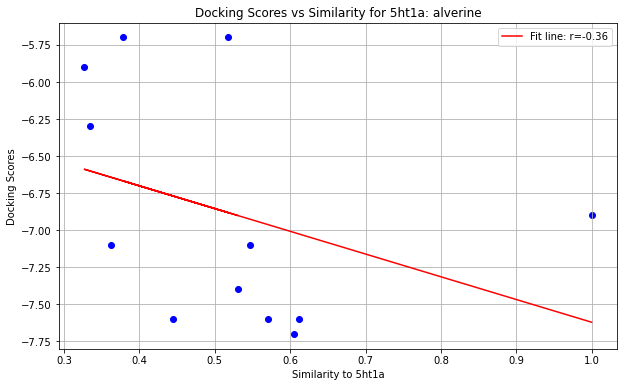

Correlation coefficient (r): -0.3618275463898506
P-value of the correlation: 0.24779677832358063


In [89]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Ensure your data is in a numpy array format, if they are in another format like list or pandas Series
similarity_5ht1a = np.array(similarity_5ht1a, dtype=float)
numerical_scores_5ht1a = np.array(numerical_scores.iloc[0, 1:], dtype=float) #this column corresponds to alverine

# Check for NaN values and handle them
if np.isnan(similarity_5ht1a).any() or np.isnan(numerical_scores_5ht1a).any():
    print("Warning: NaN values found. Consider handling them.")
else:
    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = linregress(similarity_5ht1a, numerical_scores_5ht1a)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(similarity_5ht1a, numerical_scores_5ht1a, color='blue')  # Scatter plot of your data
    plt.plot(similarity_5ht1a, intercept + slope * similarity_5ht1a, 'r', label=f'Fit line: r={r_value:.2f}')  # Regression line
    plt.title('Docking Scores vs Similarity for 5ht1a: alverine')
    plt.xlabel('Similarity to 5ht1a')
    plt.ylabel('Docking Scores')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print correlation details
    print("Correlation coefficient (r):", r_value)
    print("P-value of the correlation:", p_value)


In [90]:
#Making the first column the id column
docking_scores_extracted.set_index('Unnamed: 0', inplace=True)

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

#numerical_scores = np.array(numerical_scores.iloc[0, 1:], dtype=float)
numerical_scores_5ht1a = docking_scores_extracted
similarity_5ht1a = np.array(similarity_5ht1a)
# Iterate over each row in numerical_scores
for idx, row in numerical_scores.iterrows():
    numerical_scores_5ht1a = np.array(row, dtype=float)

    # Check for NaN values and handle them
    if np.isnan(similarity_5ht1a).any() or np.isnan(numerical_scores_5ht1a).any():
        print(f"Warning: NaN values found in row {idx}.")
        continue

    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = linregress(similarity_5ht1a, numerical_scores_5ht1a)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(similarity_5ht1a, numerical_scores_5ht1a, color='blue')  # Scatter plot of your data
    plt.plot(similarity_5ht1a, intercept + slope * similarity_5ht1a, 'r', label=f'Fit line: r={r_value:.2f}')  # Regression line
    plt.title(f'Docking Scores vs Similarity for 5ht1a - Row {idx}')
    plt.xlabel('Similarity to 5ht1a')
    plt.ylabel('Docking Scores')
    plt.legend()
    plt.grid(True)

    # Save the plot as a PNG file
    plt.savefig(f'docking_scores_vs_similarity_5ht1a_row_{idx}.png')
    plt.close()

    # Print correlation details
    print(f"Row {idx} - Correlation coefficient (r):", r_value)
    print(f"Row {idx} - P-value of the correlation:", p_value)


Row alverine - Correlation coefficient (r): -0.3618275463898506
Row alverine - P-value of the correlation: 0.24779677832358063
Row aripiprazole - Correlation coefficient (r): -0.2002078446815271
Row aripiprazole - P-value of the correlation: 0.532701000639849
Row asenapine - Correlation coefficient (r): 0.17413062416786937
Row asenapine - P-value of the correlation: 0.5883340876264198
Row buspirone - Correlation coefficient (r): 0.10895219010367005
Row buspirone - P-value of the correlation: 0.7360741122478052
Row methysergide - Correlation coefficient (r): 0.6244768376362809
Row methysergide - P-value of the correlation: 0.02995431013571906
Row naratriptan - Correlation coefficient (r): -0.2012960841158727
Row naratriptan - P-value of the correlation: 0.5304292302055116
Row pipotiazine - Correlation coefficient (r): -0.03077439087235687
Row pipotiazine - P-value of the correlation: 0.9243616989721536
Row sumatriptan - Correlation coefficient (r): -0.1748670593980908
Row sumatriptan - 

end of 5ht1a

For 5ht1b

In [118]:
docking_scores_1b = pd.read_csv('docking_scores_1b.csv')
# Apply the function to each cell in the DataFrame, excluding the first column
docking_scores_extracted_1b = docking_scores_1b.iloc[:, 1:].applymap(extract_first_number)

# Add the first column (drug names) back to the DataFrame
docking_scores_extracted_1b.insert(0, 'Unnamed: 0', docking_scores_1b['Unnamed: 0'])

In [119]:
#Making the first column the id column
docking_scores_extracted_1b.set_index('Unnamed: 0', inplace=True)

In [120]:
docking_scores_extracted_1b

,5ht1a,5ht1b,5ht1d,5ht1e,5ht1f,5ht2a,5ht2b,5ht2c,5ht4r,5ht5a,5ht6r,5ht7r
Unnamed: 0,,,,,,,,,,,,
almotriptan,-7.4,-7.5,-6.1,-7.8,-7.6,-7.1,-6.7,-7.5,-8.1,-6.2,-6.2,-7.7
asenapine,-7.4,-7.3,-7.5,-8.4,-7.7,-7.8,-8.0,-7.2,-7.7,-7.1,-7.6,-7.8
eletriptan,-8.9,-9.1,-7.7,-9.5,-8.7,-8.5,-8.1,-8.3,-7.7,-7.5,-6.9,-9.1
ergotamine,-10.7,-10.1,-9.3,-10.5,-8.6,-10.1,-10.3,-10.3,-9.2,-9.1,-8.5,-8.4
frovatriptan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
naratriptan,-7.5,-7.1,-7.6,-8.2,-8.0,-7.4,-7.4,-7.4,-8.0,-7.0,-6.1,-8.2
rizatriptan,-6.6,-6.5,-6.6,-7.1,-6.9,-6.9,-6.7,-6.6,-7.3,-6.1,-5.9,-5.9
sumatriptan,-6.5,-6.3,-6.5,-7.0,-6.6,-6.4,-6.2,-6.6,-6.9,-5.8,-5.6,-5.8
vortioxetine,-7.2,-8.0,-7.2,-8.0,-8.6,-8.1,-7.6,-8.0,-7.2,-7.1,-7.2,-8.1


In [121]:
#numerical_scores = np.array(numerical_scores.iloc[0, 1:], dtype=float)
numerical_scores_5ht1b = docking_scores_extracted_1b
similarity_5ht1b = np.array(similarity_5ht1b)
# Iterate over each row in numerical_scores
for idx, row in numerical_scores_5ht1b.iterrows():
    numerical_scores_5ht1b = np.array(row, dtype=float)

    # Check for NaN values and handle them
    if np.isnan(similarity_5ht1b).any() or np.isnan(numerical_scores_5ht1b).any():
        print(f"Warning: NaN values found in row {idx}.")
        continue

    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = linregress(similarity_5ht1a, numerical_scores_5ht1a)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(similarity_5ht1b, numerical_scores_5ht1b, color='blue')  # Scatter plot of your data
    plt.plot(similarity_5ht1b, intercept + slope * similarity_5ht1b, 'r', label=f'Fit line: r={r_value:.2f}')  # Regression line
    plt.title(f'Docking Scores vs Similarity for 5ht1b - Row {idx}')
    plt.xlabel('Similarity to 5ht1b')
    plt.ylabel('Docking Scores')
    plt.legend()
    plt.grid(True)

    # Save the plot as a PNG file
    plt.savefig(f'docking_scores_vs_similarity_5ht1b_row_{idx}.png')
    plt.close()

    # Print correlation details
    print(f"Row {idx} - Correlation coefficient (r):", r_value)
    print(f"Row {idx} - P-value of the correlation:", p_value)

Row almotriptan - Correlation coefficient (r): -0.0953075158175227
Row almotriptan - P-value of the correlation: 0.7682717075110397
Row asenapine - Correlation coefficient (r): -0.0953075158175227
Row asenapine - P-value of the correlation: 0.7682717075110397
Row eletriptan - Correlation coefficient (r): -0.0953075158175227
Row eletriptan - P-value of the correlation: 0.7682717075110397
Row ergotamine - Correlation coefficient (r): -0.0953075158175227
Row ergotamine - P-value of the correlation: 0.7682717075110397
Row naratriptan - Correlation coefficient (r): -0.0953075158175227
Row naratriptan - P-value of the correlation: 0.7682717075110397
Row rizatriptan - Correlation coefficient (r): -0.0953075158175227
Row rizatriptan - P-value of the correlation: 0.7682717075110397
Row sumatriptan - Correlation coefficient (r): -0.0953075158175227
Row sumatriptan - P-value of the correlation: 0.7682717075110397
Row vortioxetine - Correlation coefficient (r): -0.0953075158175227
Row vortioxetine

The ligands can be visualised using this function:

All other serotoninergic GPCRs

In [ ]:
docking_scores_1d = pd.read_csv('docking_scores_1d.csv')
docking_scores_1f = pd.read_csv('docking_scores_1f.csv') #no 5ht1e ligands were considered
docking_scores_2a = pd.read_csv('docking_scores_2a.csv')
docking_scores_2b = pd.read_csv('docking_scores_2b.csv')
docking_scores_2c = pd.read_csv('docking_scores_2c.csv')
docking_scores_4r = pd.read_csv('docking_scores_4r.csv')
docking_scores_5a = pd.read_csv('docking_scores_5a.csv')
docking_scores_6r = pd.read_csv('docking_scores_6r.csv')
docking_scores_7r = pd.read_csv('docking_scores_7r.csv')

# Apply the function to each cell in the DataFrame, excluding the first column
docking_scores_extracted_1d = docking_scores_1d.iloc[:, 1:].applymap(extract_first_number)
docking_scores_extracted_1f = docking_scores_1f.iloc[:, 1:].applymap(extract_first_number)
docking_scores_extracted_2a = docking_scores_2a.iloc[:, 1:].applymap(extract_first_number)
docking_scores_extracted_2b = docking_scores_2b.iloc[:, 1:].applymap(extract_first_number)
docking_scores_extracted_2c = docking_scores_2c.iloc[:, 1:].applymap(extract_first_number)
docking_scores_extracted_4r = docking_scores_4r.iloc[:, 1:].applymap(extract_first_number)
docking_scores_extracted_5a = docking_scores_5a.iloc[:, 1:].applymap(extract_first_number)
docking_scores_extracted_6r = docking_scores_6r.iloc[:, 1:].applymap(extract_first_number)
docking_scores_extracted_7r = docking_scores_7r.iloc[:, 1:].applymap(extract_first_number)

# Add the first column (drug names) back to the DataFrame
docking_scores_extracted_1d.insert(0, 'Unnamed: 0', docking_scores_1d['Unnamed: 0'])
docking_scores_extracted_1f.insert(0, 'Unnamed: 0', docking_scores_1f['Unnamed: 0'])
docking_scores_extracted_2a.insert(0, 'Unnamed: 0', docking_scores_2a['Unnamed: 0'])
docking_scores_extracted_2b.insert(0, 'Unnamed: 0', docking_scores_2b['Unnamed: 0'])
docking_scores_extracted_2c.insert(0, 'Unnamed: 0', docking_scores_2c['Unnamed: 0'])
docking_scores_extracted_4r.insert(0, 'Unnamed: 0', docking_scores_4r['Unnamed: 0'])
docking_scores_extracted_5a.insert(0, 'Unnamed: 0', docking_scores_5a['Unnamed: 0'])
docking_scores_extracted_6r.insert(0, 'Unnamed: 0', docking_scores_6r['Unnamed: 0'])
docking_scores_extracted_7r.insert(0, 'Unnamed: 0', docking_scores_7r['Unnamed: 0'])

#Make the first column the id column
docking_scores_extracted_1d.set_index('Unnamed: 0', inplace=True)
docking_scores_extracted_1f.set_index('Unnamed: 0', inplace=True)
docking_scores_extracted_2a.set_index('Unnamed: 0', inplace=True)
docking_scores_extracted_2b.set_index('Unnamed: 0', inplace=True)
docking_scores_extracted_2c.set_index('Unnamed: 0', inplace=True)
docking_scores_extracted_4r.set_index('Unnamed: 0', inplace=True)
docking_scores_extracted_5a.set_index('Unnamed: 0', inplace=True)
docking_scores_extracted_6r.set_index('Unnamed: 0', inplace=True)
docking_scores_extracted_7r.set_index('Unnamed: 0', inplace=True)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Assuming docking_scores_extracted and similarity_data are defined elsewhere in your code
# Define a list of receptor names and their abbreviations
receptors = [
    ('5ht1d', '1d'), ('5ht1f', '1f'), ('5ht2a', '2a'), 
    ('5ht2b', '2b'), ('5ht2c', '2c'), ('5ht4r', '4r'), 
    ('5ht5a', '5a'), ('5ht6r', '6r'), ('5ht7r', '7r')
]

# Function to process each receptor
def process_receptor(receptor_full, receptor_abbr):
    numerical_scores = docking_scores_extracted[receptor_abbr]
    similarity = np.array(similarity_[receptor_full])
    
    for idx, row in numerical_scores.iterrows():
        numerical_scores = np.array(row, dtype=float)

        # Check for NaN values and handle them
        if np.isnan(similarity).any() or np.isnan(numerical_scores).any():
            print(f"Warning: NaN values found in row {idx} for {receptor_full}.")
            continue

        # Calculate linear regression
        slope, intercept, r_value, p_value, std_err = linregress(similarity, numerical_scores)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(similarity, numerical_scores_row, color='blue')  # Scatter plot of your data
        plt.plot(similarity, intercept + slope * similarity, 'r', label=f'Fit line: r={r_value:.2f}')  # Regression line
        plt.title(f'Docking Scores vs Similarity for {receptor_full} ({receptor_abbr}) - Row {idx}')
        plt.xlabel(f'Similarity to {receptor_full} ({receptor_abbr})')
        plt.ylabel('Docking Scores')
        plt.legend()
        plt.grid(True)

        # Save the plot as a PNG file
        plt.savefig(f'docking_scores_vs_similarity_{receptor_abbr}_row_{idx}.png')
        plt.close()

        # Print correlation details
        print(f"Row {idx} - {receptor_full} ({receptor_abbr}) - Correlation coefficient (r):", r_value)
        print(f"Row {idx} - {receptor_full} ({receptor_abbr}) - P-value of the correlation:", p_value)

# Iterate over each receptor in the list and process
for receptor_full, receptor_abbr in receptors:
    process_receptor(receptor_full, receptor_abbr)


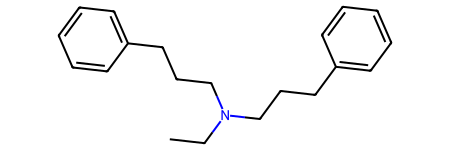

In [79]:
#Visualizing ligand structures, alverine example (5ht1a ligand)
Chem.MolFromSmiles(variable_dict['alverine'])